In [1]:
from common import *
import globals as top_imports
top_imports.use_N = True
from given import *
import re

In [2]:
quarter = lambda time: (lambda time: (time.dt.year+(time.dt.quarter-1)/4).astype(np.float32))(pd.Series(time))
halfYear = lambda time: (quarter(time)*2).astype(int).values/2

In [3]:
pd.set_option('display.max_colwidth', 115)

In [4]:
def setup_N(*, N):
    #_N_ = get_N() #pd.read_pickle(the_data/'trans/N10.pkl') #get_N()
    N['assetName'] = N.assetName.astype(str)
    N['assetNameId'] = N.assetName.map(assetNameIdAssign)
    N['assetNamesCount'] = N[['sourceId','assetNameId']].groupby('sourceId').transform('count')
    #N['assetNames'] = N[['sourceId','assetNameId']].groupby('sourceId').transform(frozenset)
    N['firstMentionFixed'] = N.firstMentionSentence.replace(0, 999)

    @njit
    def make_news_groupby_day(ref, col):
        '''Params - ref: np.ndarray {1d} should be something like np.unique(M.time.values)
                    col: np.ndarray {1d} should be something like N.time.values
        Return N.time mapped to the corresponding M.time values
        '''
        i, j = 0, 0
        ret = col.copy()
        for j in range(len(col)):
            while ref[i] < col[j]:
                i += 1
            ret[j] = ref[i]
        return ret
    N['groupbyTime'] = pd.Series(make_news_groupby_day(np.unique(M.time.values), N.time.values)).astype(M.time.dtype)

In [5]:
# N = _N_small = _N_[('2015-01-01'<=_N_.time)&(_N_.time<'2015-04-01')]

NameError: name '_N_' is not defined

In [7]:
from akamap import akamap
xAssetNames = set(assetNameIdAssign.series)
_flag = False
for x in akamap:
    if x not in xAssetNames:
        _flag = True
        print(x)
assert not _flag

# Helpers

In [8]:
ljust = lambda s: s.str.ljust(s.str.len().max())
def ljust_c(columns):
    if isinstance(columns, str):
        columns = [columns]
    def ljust_df(df):
        df = df.copy()
        for c in columns:
            df[c] = ljust(df[c])
        return df
    return ljust_df

In [9]:
def sample(k):
    def sample_k(df):
        n = len(df)
        samps = sorted(random.sample(range(n), k))
        return df.iloc[samps]
    return sample_k

# Notes and TODOs

In [10]:
'STCKa.O vs STCKb.O';

In [11]:
'''
stock matching algorithm:
    match whole
    loop take away one token from right and try match
    repeat above with symbols removed (add no space)
''';

In [12]:
'''
preprocessing pipeline:
    replace \ => [delete]
    replace ` => '
    convert numbers
    convert stock ticker symbols
    replace ... => #ellipsis
    replace . => [delete]
    replace -- => #dash
    replace [symbol not backslash] => [same symbol with spaces on either side]
    lowercase
    split
    remove stock endings words
    match stock name
        match canonical name in decreasing num words right to left
            also try get rid of symbol words inside decreasing word loop # also commas before Inc, Ltd
        repeat prev 2 lines with all aka names
            order of which choose aka names as follows:
                if aka maps to list, do canon name first, then the list in order
                if aka maps to one str, see if wordified the aka str is sublist of canon name,
                    if so, do canon name first, then aka name
                    else, do aka name first, then canon
    remove CORPORATION/INCORPORATED and the likes from after the stock mention #TODO
''';

# Preprocessing

In [13]:
def make_replacer(key_values):
    try:
        replace_dict = dict(key_values)
    except (TypeError, ValueError):
        replace_dict = {a: '' for a in key_values}
    replacement_function = lambda match: replace_dict[match.group(0)]
    pattern = re.compile("|".join([re.escape(k) for k, v in replace_dict.items()]), re.M)
    return lambda string: pattern.sub(replacement_function, string)

## real code

#### define some constants

In [14]:
corpFull = {
    'Incorporated': 'Inc',
    ',Incorporated': ',Inc',
    'Corporation': 'Corp',
    'Company': 'Co',
    'Limited': 'Ltd',
    ',Limited': ',Ltd',
    ',Limited Liability Company': 'LLC',
    ',Limited Liability Company': ',LLC',
    'Public Limited Company': 'PLC',
    ',Public Limited Company': ',PLC',
    'Limited Partnership': ['LP', 'L P'],
    ',Limited Partnership': [',LP', ', L P'],
    'Companies': 'Cos',
    'Societe anonyme': ['SA','S A'],
    'Naamloze vennootschap': ['NV', 'N V'],
    # AS A/S ASA full names don't show up in news
    'Aktiengesellschaft': 'AG',
}
corpAbbrMapFull = {}
for full, abbrs in corpFull.items():
    if isinstance(abbrs, str):
        abbrs = [abbrs]
    for abbr in abbrs:
        corpAbbrMapFull[abbr] = full
corpFull = list(corpFull.keys())
corpAbbr = 'Inc ,Inc Corp Co Ltd ,Ltd LLC ,LLC PLC ,PLC LP ,LP Cos SA ,SA NV ,NV ASA A/S AS PAO AG'.split()
corpAbbr += ['S A',', S A','L P','P L C','N V','SA de CV',',SA de CV']
corpSpec = 'co company cos companies'.split()

#### simple subs

In [15]:
if TEST:
    re_money = re.compile(r'(?<!\w)\$[0-9]+(,[0-9][0-9][0-9])*.?[0-9]*')
    re_money.search('hi :$5,666.00').group(0)
    re_year = re.compile(r'(?<![0-9])('+'|'.join(str(i) for i in range(1999, 2022))+')(?![0-9])')
    re_year.search('hi what 2009e  ').group()
    re_percent = re.compile(r'(?<!\w)[0-9]+(,[0-9][0-9][0-9])*\.?[0-9]*\%')
    re_percent.search('hi 66%').group()

In [16]:
class resub(metaclass=staticclass):
    @classmethod
    def replace(cls, text):
        return cls.re.sub(cls.put, text)

# stupid fucking re.sub interprets backslash+<char> as escape sequences IN THE REPLACEMENT STRING!
# like, bitch, I give you a string when I could have equally well given you a function, I want you to take it as it fck'ng is
    
class HPL(metaclass=staticclass): # headline @pipeline #TODO test the regexes
    class Money(resub):
        re = re.compile(r'[\$\¤\¥\£\€]\ ?[0-9]+(\,[0-9][0-9][0-9])*\.?[0-9]*')
        put = r'\\money'+'\\'*4
    class Percent(resub): # a percent number - if connected to words don't include
        re = re.compile(r'(?<!\w)[0-9]+(\,[0-9][0-9][0-9])*\.?[0-9]*\%')
        put = r'\\decimal'+'\\'*4
    class Year(resub): # any digits that look like dates will be replaced
        re = re.compile(r'(?<![0-9])('+'|'.join(str(i) for i in range(2008, 2020))+'|'
                        +'|'.join(fr"\'{i:02}" for i in range(8,20))+')(?![0-9])')
        put = r'\\year'+'\\'*4
    class Decimal(resub): # a number with decimals - if connected to words don't include
        re = re.compile(r'(?<!\w)[0-9]+(,[0-9][0-9][0-9])*\.[0-9]+(?!\w)')
        put = r'\\decimal'+'\\'*4
    class Count(resub): # a natural number - if connected to words don't include
        re = re.compile(r'(?<!\w)[0-9]+(,[0-9][0-9][0-9])*(?!\w)')
        def put(match):
            guy = match.group().replace(',', '')
            sz = str(len(guy) if guy[0] not in '01' else len(guy)-1)
            return '\\count\\' + sz + r'\\'
        
    class Misc(resub): # add spaces around symbols that are not backslash
        re = re.compile(r'[^\w\.\s\\]')
        put = lambda match: ' ' + match.group() + ' '
    
    # post wordify
    
    class Quarter(resub):
        re = re.compile(r'\ '+
            r'(q1|q2|q3|q4|(first|1st|second|2nd|third|3rd|fourth|4th)\ \ quarter|quarter\ \ \\count\\(0|1)\.)'+
        r'\ ')
        put = r' \\quarter\\labelled. '
    class Month(resub):
        re = re.compile(r'\ (january|jan|february|feb|march|mar|april|apr|may|june|jun|july|jul|august|aug|'+
                        r'september|sep|sept|october|oct|november|nov|december|dec)\ ')
        put = r' \\month. '
    class Possesive(resub):
        re = re.compile(r'\ \'\ \ s\ ')
        put = r' \\possesive. '
    
# put into HPL context: HPL.self (an assetNameId) and HPL.assets (container of assetNameIds)
    
@inside(HPL)
class Ticker(resub):
    re_lowercase = re.compile(r'[a-z]')
    def norm(ticker):
        ticker = Ticker.re_lowercase.sub('', ticker)
        return ticker[:ticker.index('.')] if '.' in ticker else ticker
    
    re = re.compile(r'<[A-Z]+[a-z]*.?[A-Z]*>')
    
    def put(match):
        try:
            codes = assetNameMapCodes[HPL.self]
        except KeyError:
            return r' \ticker\\ '
        normed = Ticker.norm(match.group()[1:-1]) # match.group() is of form <AAPL.O>
        if any(Ticker.norm(x)==normed for x in assetCodeIdAssign.series[list(codes)]):
            return r' \ticker\self\\ '
        else:
            return r' \ticker\\ '

In [17]:
@inside(HPL)
def listify(text):
    text = text.replace('\\','').replace('`',"'")
    text = compose(*[getattr(getattr(HPL,a),'replace') for a in ['Year','Money','Percent','Decimal','Count']])(text)
    text = HPL.Ticker.replace(text)
    text = text.replace('...',r' \ellipsis\\ ').replace('.','').replace('\\\\','.').replace('--','—')
    text = HPL.Misc.replace(text).lower()
    return text.split()

@inside(HPL)
def wordify(text):
    return ' '+'  '.join(HPL.listify(text))+' '

@inside(HPL)
def postproc(text):
    return compose(*[getattr(getattr(HPL,a),'replace') for a in ['Quarter','Month','Possesive']])(text)

In [19]:
# store the wordified things inside one place

@inside(HPL, name='words')
class words(O()):
    cAbbr = list(map(HPL.wordify, corpAbbr))
    cFull = list(map(HPL.wordify, corpFull))
    cSpec = list(map(HPL.wordify, corpSpec))

_replace_corpwords = make_replacer(HPL.words.cAbbr)
_rp = lambda x: _replace_corpwords(HPL.wordify(x))
HPL.words.assetNameSeries = assetNameIdAssign.series.map(_rp)
HPL.words.akamap = {x: (list([_rp(y)]) if isinstance(y, str) else list(map(_rp, y))) for x,y in dict.items(akamap)}


# store the regex of wordified things in one place

@memoized
def _make_stock_ending():
    maybe = '('+'|'.join(re.escape(' '+a+' ') for a in HPL.words.cSpec)+')?'
    corps = '('+'|'.join(re.escape(a) for a in HPL.words.cAbbr+HPL.words.cFull)+')?'
    return maybe+corps

def make_regex_for_stock(words): #TODO save time by considering only relevant stock endings
    lst = words.split()
    def rec_make_sub_chain(lst):
        return re.escape(' '+lst[0]+' ') if len(lst)==1 else re.escape(' '+lst[0]+' ')+'('+rec_make_sub_chain(lst[1:])+')?'
    return re.compile(rec_make_sub_chain(lst)+_make_stock_ending())


@inside(HPL, name='regex')
class regex(O()):
    assetNameSeries = HPL.words.assetNameSeries.map(make_regex_for_stock)
    akamap = {x: list(map(make_regex_for_stock, y)) for x,y in dict.items(HPL.words.akamap)}

In [20]:
# @inside(HPL) 
# def match_stocks(words):
#     for asset in HPL.assets:
#         put = r'\asset\self.' if asset==HPL.self else r'\asset.'
#         assetWords = HPL.words.assetNameSeries.loc[asset]
#         for i in range(len(assetWords), 0, -1):
#             useWords = assetWords[:i]
#             k = 0
#             while k+i <= len(words):
#                 if words[k:k+i] == useWords:
#                     words[k:k+i] = [put]
#                 k += 1
#     return words

@inside(HPL)
def match_stocks(words):
    for asset in [HPL.self] + [a for a in HPL.assets if a!=HPL.self]:
        put = r' \\asset\\self. ' if asset==HPL.self else r' \\asset. '
        
        assetCanon = assetNameIdAssign.series.loc[asset]
        assetWords, assetRegex = HPL.words.assetNameSeries.loc[asset], HPL.regex.assetNameSeries.loc[asset]
        akaWords, akaRegex = HPL.words.akamap.get(assetCanon, []), HPL.regex.akamap.get(assetCanon, [])
        if len(akaWords)==0:
            assetRegexList = [assetRegex]
        elif len(akaWords)==1 and next(iter(akaWords)) not in assetWords:
            assetRegexList = [next(iter(akaRegex)), assetRegex]
        else:
            assetRegexList = [assetRegex] + list(akaRegex)
        
        for assetRegex in assetRegexList:
            words = assetRegex.sub(put, words)
    return words

In [21]:
def transform_headlines(*, N):
    ret = [None] * len(N)
    # idk probably save time looking up N's hash table:
    sourceIds, assetNameIds, inHeadline = N.sourceId.values, N.assetNameId.values, (N.firstMentionSentence==1).values
    hTags, hTagIds = N.headlineTag.values, N.headlineTagId.values
    new_i = 0 # this tracks grouping of sourceIds
    # basically, I see that same sourceIds are always consecutive. so every time I see new news item I walk down table
    # to see where the same news item ends, and collect all the assetNameIds along the way and keep them for use
    print('['+str(len(N.headline))+']', end='')
    for i, text in enumerate(N.headline.values):
        print_progress(i, 1000)
        if i == new_i: # starting a new sourceId group, have to look ahead to see where it ends and gather assetNameIds
            HPL.assets = set()
            while new_i<len(sourceIds) and sourceIds[new_i]==sourceIds[i]:
                if inHeadline[new_i]:
                    HPL.assets.add(assetNameIds[new_i])
                new_i += 1
        HPL.self = assetNameIds[i]
        
        tag = hTags[i]
        text = text.strip()
        if tag and text[:len(tag)]==tag:
            _has_tag = True
            text = text[len(tag):].lstrip()
            if text[0] in '-–—:':
                text = text[1:]
                text = text.lstrip()
        else:
            _has_tag = False
            
        ret[i] = compose(HPL.wordify,HPL.match_stocks,HPL.postproc)(text)
        
        if _has_tag:
#             ret[i] = [fr'\htag\{hTagIds[i]}.', r'\htag\conn.'] + ret[i]
            ret[i] = fr' \htag\{hTagIds[i]}.  \htag\conn. ' + ret[i]
        
    N['headlineWords'] = ret

#### go do it

In [18]:
%%time
N = _N_.pipe(lambda N: N[N.assetNameId.isin(assetNameMapCodes)])
transform_headlines(N=N)

[7114576]0.........10000.........20000.........30000.........40000.........50000.........60000.........70000.........80000.........90000.........100000.........110000.........120000.........130000.........140000.........150000.........160000.........170000.........180000.........190000.........200000.........210000.........220000.........230000.........240000.........250000.........260000.........270000.........280000.........290000.........300000.........310000.........320000.........330000.........340000.........350000.........360000.........370000.........380000.........390000.........400000.........410000.........420000.........430000.........440000.........450000.........460000.........470000.........480000.........490000.........500000.........510000.........520000.........530000.........540000.........550000.........560000.........570000.........580000.........590000.........600000.........610000.........620000.........630000.........640000.........650000.........660000.........

......5190000.........5200000.........5210000.........5220000.........5230000.........5240000.........5250000.........5260000.........5270000.........5280000.........5290000.........5300000.........5310000.........5320000.........5330000.........5340000.........5350000.........5360000.........5370000.........5380000.........5390000.........5400000.........5410000.........5420000.........5430000.........5440000.........5450000.........5460000.........5470000.........5480000.........5490000.........5500000.........5510000.........5520000.........5530000.........5540000.........5550000.........5560000.........5570000.........5580000.........5590000.........5600000.........5610000.........5620000.........5630000.........5640000.........5650000.........5660000.........5670000.........5680000.........5690000.........5700000.........5710000.........5720000.........5730000.........5740000.........5750000.........5760000.........5770000.........5780000.........5790000.........5800000.........58

In [45]:
N.to_pickle(the_data/'trans/N1010.pkl')

#### let's see the results

In [22]:
N = _N_ = pd.read_pickle(the_data/'trans/N1010.pkl')

In [163]:
seeN = N.pipe(sample(10))
seeN.headlineWords.map(lambda x: ' '.join(grams4[x.split()]))

26187                      webcast_alert : \asset\self. announces \quarter\labelled. \count\4. earnings webcast \ticker\self.
1168961                                   \htag\95. \htag\conn. \asset\self. amends and extends equity forward sale agreement
1358545    \asset\self. microsystems announces production shipments of the industry ' s first knowledge - based \ellipsis....
3262523                                                    barron ' s sees stock market rise ; picks \count\1. top big - caps
3924890                                                 \htag\98. \htag\conn. s &_p \count\3. \month. \count\1. \count\3._gmt
5073508                                                                   \asset\self. launches \asset\self. payment exchange
7017872                             \asset\self. opens denver office and hires executive_vice president of land \ticker\self.
7422198                                      \htag\14. \htag\conn. union investment hires benjardin gartner from \asse

In [133]:
seeN[['assetName','assetCodes','headlineTag','headline']];

In [134]:
seeN.headlineWords;

#### see more crap

# Embed

In [23]:
from gensim.models import FastText
from gensim.models.phrases import Phrases, Phraser

In [24]:
N['headlineFeeds'] = N.headlineWords.map(lambda x: x.split())
del N['headlineWords']; gc.collect()

14

In [ ]:
%%time
grams2 = Phrases(iter(N.headlineFeeds)); grams2 = Phraser(grams2); grams2.save('../data/news/grams2')
grams3 = Phrases(grams2[iter(N.headlineFeeds)]); grams3 = Phraser(grams3); grams3.save('../data/news/grams3')
grams4 = Phrases(grams3[grams2[iter(N.headlineFeeds)]]); grams4 = Phraser(grams4); grams4.save('../data/news/grams4')
phrases = lambda x: grams4[grams3[grams2[x]]]

In [25]:
%%time
grams2 = Phraser.load('../data/news/grams2')
grams3 = Phraser.load('../data/news/grams3')
grams4 = Phraser.load('../data/news/grams4')
phrases = lambda x: grams4[grams3[grams2[x]]]

CPU times: user 1.66 s, sys: 186 ms, total: 1.84 s
Wall time: 1.8 s


In [23]:
%%time
bed = FastText(phrases(feeds), size=120, window=5, min_count=20, workers=12, sg=1, seed=0)

CPU times: user 3h 14min 21s, sys: 3.44 s, total: 3h 14min 24s
Wall time: 2h 28min 18s


In [26]:
#bed.save('../data/news/FT_size120_window5_mincount20_sg1_seed0')
bed = FastText.load('../data/news/FT_size120_window5_mincount20_sg1_seed0')

LOOK HERE

In [81]:
bed.wv.most_similar(r'')

[('unexpectedly', 0.8049476742744446),
 ('experienced', 0.6410397291183472),
 ('posturing', 0.6384972333908081),
 ('surprising', 0.6362307667732239),
 ('caused', 0.6239986419677734),
 ('causing', 0.6239521503448486),
 ('discounting', 0.6214480400085449),
 ('precautionary', 0.6193425059318542),
 ('interruptions', 0.6138929724693298),
 ('experiencing', 0.612444281578064)]

In [27]:
vectify = lambda x: bed[grams4[grams3[grams2[x]]]]

In [28]:
from keras.layers import Dense, Input, Flatten, TimeDistributed
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Embedding, Dropout
from keras.models import Model, load_model
_td = TimeDistributed

Using TensorFlow backend.


In [40]:
class dim(O()):
    NewsInDay = None
    WordsInHeadline = 36
    WordsEmbedding = 120
    
entry = Input(shape=(dim.NewsInDay,dim.WordsInHeadline,dim.WordsEmbedding))
conv0 = _td(Conv1D(80, kernel_size=3, strides=1, padding='valid', activation='relu'))(entry)
pool0 = _td(MaxPooling1D(3))(conv0)
conv1 = _td(Conv1D(40, 5, activation='relu'))(pool0)
pool1 = _td(MaxPooling1D(5))(conv1)
globe = _td(Flatten())(pool1)
dense = _td(Dense(6, activation='relu'))(globe)
aggs = GlobalMaxPooling1D()(dense)
pred = Dense(1, activation='sigmoid')(aggs)

In [41]:
model = Model(entry, pred)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
M['y'] = M.returnsOpenNextMktres10

In [43]:
%%time
tmMapIndex = {(row.time,row.assetCodeId):i for i,row in enumerate(M.itertuples()) if row.universe}
tnMapIndices = {}
for i,row in enumerate(N.itertuples()):
    if row.headlineFeeds:
        tnMapIndices.setdefault((row.groupbyTime,row.assetNameId), []).append(i)

CPU times: user 3min 10s, sys: 7.47 s, total: 3min 18s
Wall time: 3min 16s


In [44]:
def vectify_reshape(a):
    if len(a) > dim.WordsInHeadline:
        a = a[:dim.WordsInHeadline]
    elif len(a) < dim.WordsInHeadline:
        a = np.concatenate([a, np.zeros((dim.WordsInHeadline-len(a), a.shape[1]))], axis=0)
    return a

def index_batches(N):
    for time, theN in N.groupby('groupbyTime'):
        theN = theN.sample(frac=1)
        oneday = list(theN.groupby('assetNameId'))
        random.shuffle(oneday)
        mi = []
        nis = []
        for aName, theN in oneday:
            
            theN = theN[theN.headlineFeeds.map(bool)] # get rid of empty lists of words
            if len(theN) == 0:
                continue
                
            try:
                vectified = np.stack(theN.headlineFeeds.map(vectify).map(vectify_reshape).head(1), axis=0)
            except KeyError: # fucking FastText errors out when given unseen ngram (WHY CAN'T YOU JUST GIVE RANDOM ANSWER)
                continue
                
            aCodes = list(assetNameMapCodes[aName])
            for aC in aCodes:
                if (time, aC) in tmMapIndex:
                    mi.append(tmMapIndex[time,aC])
                    nis.append(tnMapIndices[time,aName]);

            if len(mi) > 32:
                yield mi, nis
                mi = []
                nis = []
        if len(mi) != 0:
            yield mi, nis
            
def iter_batches(N, indices):
    i = 0
    def _yield(X, Y):
        BUG.X, BUG.Y = X, Y
        nonlocal i; print_progress(i, 10); i += 1
        Y = Y.values
        target = (Y > 0).astype(float)
        weight = np.abs(Y)
        X = np.stack(X, axis=0)
        return X, target, weight
    
    print(f'[{len(indices)}]', end='')
    for mi_, nis_ in indices:
        BUG.mi_, BUG.nis_ = mi_, nis_
        
        X = []
        Y = M.y.iloc[mi_]
        
        for nis in nis_:
            theN = N.iloc[nis]
            
#             theN = theN[theN.headlineFeeds.map(bool)] # get rid of empty lists of words
#             if len(theN) == 0:
#                 continue
            
            vectified = np.stack(theN.headlineFeeds.map(vectify).map(vectify_reshape).head(1), axis=0)
            X.append(vectified)

        yield _yield(X, Y)

In [301]:
%%time
batch_indices = list(index_batches(N))

CPU times: user 1h 36min 29s, sys: 0 ns, total: 1h 36min 29s
Wall time: 1h 36min 28s


In [302]:
pd.to_pickle(batch_indices, '../data/news/batch_indices.pkl')

In [45]:
batch_indices = pd.read_pickle('../data/news/batch_indices.pkl')

In [294]:
# %%time
# q = quarter(N.groupbyTime)
# model.fit_generator(iter_data(N[(2009.<=q)&(q<2015.5)]), steps_per_epoch=len(M)//32)

Epoch 1/1
   218/127279 [..............................] - ETA: 6:37:34 - loss: 0.0214 - acc: 0.5695

KeyboardInterrupt: 

In [352]:
/display M.iloc[batch_indices[3621][0][0]].time
/display M.iloc[batch_indices[3622][0][0]].time

Timestamp('2008-12-31 22:00:00+0000', tz='UTC')

Timestamp('2009-01-02 22:00:00+0000', tz='UTC')

In [353]:
/display M.iloc[batch_indices[18422][0][0]].time
/display M.iloc[batch_indices[18423][0][0]].time

Timestamp('2015-06-30 22:00:00+0000', tz='UTC')

Timestamp('2015-07-01 22:00:00+0000', tz='UTC')

In [46]:
%%time
the_batches = chain(*[iter_batches(N, batch_indices[3622:18423]) for i in range(5)])
model.fit_generator(the_batches, steps_per_epoch=len(batch_indices[3622:18423]), epochs=5);

Epoch 1/5
14801/14801 [==============================] - 1852s 125ms/step - loss: 0.0260 - acc: 0.509301
Epoch 2/5
14801/14801 [==============================] - 1856s 125ms/step - loss: 0.0261 - acc: 0.507701
Epoch 3/5
14801/14801 [==============================] - 1860s 126ms/step - loss: 0.0261 - acc: 0.507701
Epoch 4/5
14801/14801 [==============================] - 1858s 126ms/step - loss: 0.0261 - acc: 0.507701
Epoch 5/5
14801/14801 [==============================] - 1861s 126ms/step - loss: 0.0261 - acc: 0.5077
CPU times: user 3h 8min 37s, sys: 2min 3s, total: 3h 10min 41s
Wall time: 2h 34min 47s


In [47]:
model.save('../data/news/keras3')

In [33]:
model = load_model('../data/news/keras')

In [51]:
def filter_indices(N, indices):    
    print(f'[{len(indices)}]', end=''); i = 0
    
    for mi_, nis_ in indices:
        print_progress(i, 10); i += 1
        BUG.mi_, BUG.nis_ = mi_, nis_
        
        MI, NIS = [], []
        
        for mi, nis in zip(mi_, nis_):
            BUG.mi, BUG.nis = mi, nis
            theN = N.iloc[nis]
            
            theN = theN[theN.headlineFeeds.map(bool)] # get rid of empty lists of words
            if len(theN) == 0:
                continue
            
            MI.append(mi)
            NIS.append(nis)

        yield theN.time.iloc[0], MI, NIS

In [52]:
ho_time_batch_indices = list(filter_indices(N, batch_indices[18420:]))
ho_time = [tup[0] for tup in ho_time_batch_indices]
ho_batch_indices = [tup[1:] for tup in ho_time_batch_indices]

[3766]0.........100.........200.........300.........400.........500.........600.........700.........800.........900.........1000.........1100.........1200.........1300.........1400.........1500.........1600.........1700.........1800.........1900.........2000.........2100.........2200.........2300.........2400.........2500.........2600.........2700.........2800.........2900.........3000.........3100.........3200.........3300.........3400.........3500.........3600.........3700......

In [53]:
ho_batches_list = list(iter_batches(N, ho_batch_indices))

[3766]0.........100.........200.........300.........400.........500.........600.........700.........800.........900.........1000.........1100.........1200.........1300.........1400.........1500.........1600.........1700.........1800.........1900.........2000.........2100.........2200.........2300.........2400.........2500.........2600.........2700.........2800.........2900.........3000.........3100.........3200.........3300.........3400.........3500.........3600.........3700......

In [54]:
ans = model.predict_generator(iter(ho_batches_list), steps=len(ho_batches_list))

In [55]:
time = np.concatenate(list(np.full(len(guy[1]), ho_time[i]) for i,guy in enumerate(ho_batches_list)))
upDown = np.concatenate(list(guy[1] for guy in ho_batches_list))
absVal = np.concatenate(list(guy[2] for guy in ho_batches_list))

In [56]:
myho = pd.DataFrame(dict(time=time,upDown=upDown,absVal=absVal,pred=ans[:,0]))

In [72]:
myho['y'] = (myho.upDown*2-1)*myho.absVal
myho['guess'] = myho.pred*2-1
myho['guess'] = myho.groupby('time').guess.transform(lambda x: np.tanh((x-x.mean())*7)+x.mean())
myho['trade'] = myho.y * myho.guess

0.08238235145368322


<IPython.core.display.Javascript object>


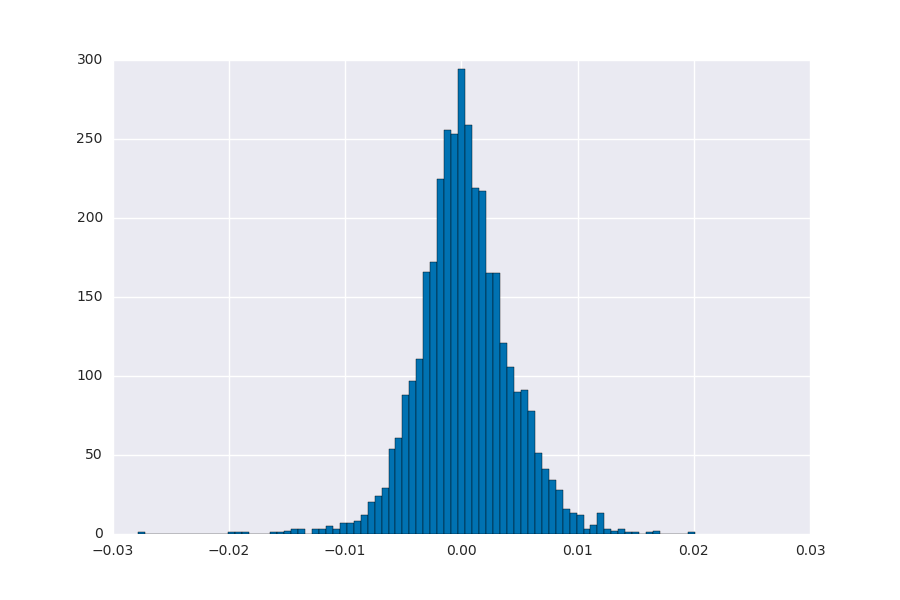

In [73]:
dl = myho.groupby('time').trade.sum()
print(dl.mean()/dl.std())
plt.hist(dl, bins=80);

In [59]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

# The old post-listify stiff

#### see which companies haven't found match

In [104]:
N = _N_

In [52]:
N['headlineList'] = N.headlineWords.map(str.split)
N['inHeadline'] = N.headlineList.map(lambda x: r'\asset\self.' in x)

CPU times: user 25.7 s, sys: 3.11 s, total: 28.8 s
Wall time: 28.7 s


In [105]:
Nnomatch = N.pipe(lambda N: N[(N.firstMentionSentence==1) & ~N.inHeadline & N.assetNameId.isin(assetNameMapCodes)])

In [107]:
nomatch = Nnomatch.assetNameId.value_counts()
nomatch.index.name, nomatch.name = nomatch.name, 'Count'

In [180]:
nomatch.reset_index(drop=True)#.plot();

In [357]:
(Nnomatch, nomatch, lookup) = pd.read_pickle('stock-help.pkl')

In [179]:
nomatch_i = 99
asset = nomatch.index[nomatch_i]
seeN = Nnomatch.pipe(lambda N: N[N.assetNameId==asset])
print(assetNameIdAssign.series.loc[asset])
seeN.headline.pipe(ljust)

In [182]:
what = 24536
_N_.loc[what-1:what+1+1]

In [381]:
oks, oke = M[M.assetCode=='OKS.N'], M[M.assetCode=='OKE.N']

In [387]:
oks.set_index('time').returnsOpenNextMktres10.corr(oke.set_index('time').returnsOpenNextMktres10)

0.6580509598009644

## just looking

In [297]:
_N_.pipe(lambda N: N.headline[N.assetNameId==7760].pipe(ljust))

20772     Asia Netcom in $636 mln trans-Pacific cable project                                                            ...
91927     PRESS DIGEST - Singapore newspapers - Feb 14                                                                   ...
290017    Singapore Hot Stocks-STATS ChipPAC in focus amid bid speculation                                               ...
321336    Pacific Internet to restate results from 2000 to 2006                                                          ...
322182    CONNECT HOLDINGS SAYS TO DATE, THERE ARE NO ALTERNATIVE OFFERS OR CONCRETE PROPOSALS AVAILABLE TO ALL SHAREHOLD...
322183    CONNECT HOLDINGS SAYS REVISED OFFER PRICE FOR PACIFIC INTERNET <PCNTF.O> REPRESENTS AN INCREASE OF 10 PCT FROM ...
324658    PRESS DIGEST - Singapore newspapers - June 8                                                                   ...
474706    PACIFIC INTERNET LTD <PCNTF.O> SAYS CEO PHEY TECK MOH TO STEP DOWN - SEC FILING                                ...


# Explore